In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 한글 폰트 설정 (환경에 따라 필요시 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows용
# plt.rcParams['font.family'] = 'AppleGothic' # Mac용
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 금융 지표 계산을 위한 스프레드, 코스피, 환율리 z-score 계산 데이터 불러오기
df_spread = pd.read_csv('new_data/new_data_z_score/Credit_Spread_Z_Score.csv', index_col='날짜', parse_dates=True)
df_kospi = pd.read_csv('new_data/new_data_z_score/new_kospi_z_score.csv', index_col='날짜', parse_dates=True)
df_exchange = pd.read_csv('new_data/new_data_z_score/USD_KRW_z_score.csv', index_col='날짜', parse_dates=True)

In [4]:
# 데이터 통합
combined_fin = df_spread[['Z_score']].rename(columns={'Z_score': 'credit_spread'}).join(
    df_kospi[['z_score']].rename(columns={'z_score': 'kospi'}), how='inner').join(
    df_exchange[['z_score']].rename(columns={'z_score': 'exchange'}), how='inner')

In [5]:
# 금융 지수 계산
combined_fin['fin_index'] = combined_fin.mean(axis=1)

In [6]:
# 형식 맞추기 및 저장
final_fin_output = combined_fin.reset_index().rename(columns={'index': 'date'})
final_fin_output = final_fin_output.dropna() # 초기 12개월분 제외

final_fin_output.to_csv('new_data/금융지표계산.csv', index=True, encoding='utf-8-sig')
print("금융 종합지표 파일이 'new_data/금융지표계산.csv'로 저장되었습니다.")

금융 종합지표 파일이 'new_data/금융지표계산.csv'로 저장되었습니다.


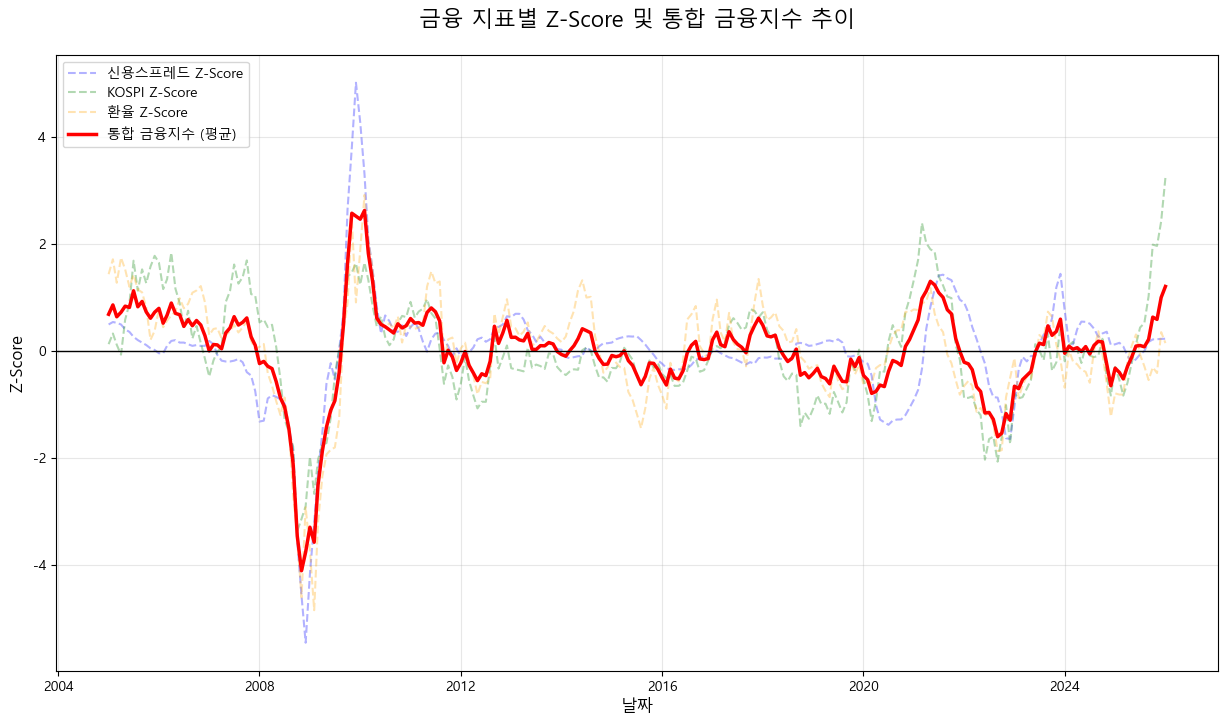

In [7]:
# 시각화
# 한글 폰트 설정 (환경에 따라 필요시 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows용
# plt.rcParams['font.family'] = 'AppleGothic' # Mac용
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 8))

# 개별 지표들 (Credit Spread, KOSPI, Exchange) 흐릿하게 출력
plt.plot(combined_fin.index, combined_fin['credit_spread'], label='신용스프레드 Z-Score', color='blue', alpha=0.3, linestyle='--')
plt.plot(combined_fin.index, combined_fin['kospi'], label='KOSPI Z-Score', color='green', alpha=0.3, linestyle='--')
plt.plot(combined_fin.index, combined_fin['exchange'], label='환율 Z-Score', color='orange', alpha=0.3, linestyle='--')

# 통합 금융 지수 (fin_index)
plt.plot(combined_fin.index, combined_fin['fin_index'], label='통합 금융지수 (평균)', color='red', linewidth=2.5)

# 기준선 (Z-score = 0) 추가
plt.axhline(0, color='black', linewidth=1, linestyle='-')

# 차트 꾸미기
plt.title('금융 지표별 Z-Score 및 통합 금융지수 추이', fontsize=16, pad=20)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()